In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.initializers import HeNormal
from keras.callbacks import ModelCheckpoint
from matplotlib import image
from matplotlib import pyplot
import os
import shutil
import numpy as np
from PIL import Image
import pickle
from sklearn.preprocessing import MultiLabelBinarizer



In [ ]:
from keras.applications.resnet import ResNet50, decode_predictions

In [ ]:
pathToData = "drive/MyDrive/CS 230 Final Project/ResNet Data/"
print(pathToData + "trainRes_X.p")
pathToModels = "drive/MyDrive/CS 230 Final Project/SavedModelsFromTraining/"
print(pathToModels)

drive/MyDrive/CS 230 Final Project/ResNet Data/trainRes_X.p
drive/MyDrive/CS 230 Final Project/SavedModelsFromTraining/


In [ ]:
mlb = MultiLabelBinarizer()
# load the train dataset
X_train = pickle.load(open(pathToData+"trainRes_X.p", 'rb'))
y_trainUnflat = pickle.load(open(pathToData+"trainRes_Y.p", 'rb'))
y_train = y_trainUnflat.reshape(y_trainUnflat.shape[0],-1)
y_train = mlb.fit_transform(y_train)

print(X_train.shape)
print(y_train.shape)

# load the dev dataset
X_dev = pickle.load(open(pathToData+"devRes_X.p", 'rb'))
y_devUnflat = pickle.load(open(pathToData+"devRes_Y.p", 'rb'))
y_dev = y_devUnflat.reshape(y_devUnflat.shape[0],-1)
y_dev = mlb.fit_transform(y_dev)

print(X_dev.shape)
print(y_dev.shape)

# load the test dataset
X_test = pickle.load(open(pathToData+"testRes_X.p", 'rb'))
y_testUnflat = pickle.load(open(pathToData+"testRes_Y.p", 'rb'))
y_test = y_testUnflat.reshape(y_testUnflat.shape[0],-1)
y_test = mlb.fit_transform(y_test)

print(X_test.shape)
print(y_test.shape)

(4246, 224, 224, 3)
(4246, 3)
(910, 224, 224, 3)
(910, 3)
(910, 224, 224, 3)
(910, 3)


In [ ]:
print(y_trainUnflat)

[0 2 1 ... 0 1 0]


In [ ]:
numExamples = X_train.shape[0]
print(numExamples)

4246


In [ ]:
print(X_train.shape)

(4246, 224, 224, 3)


In [ ]:
print(X_train.shape[1:])

(224, 224, 3)


In [ ]:
model = ResNet50(include_top=True, weights=None, input_shape=(X_train.shape[1:]), classes=3)


In [ ]:
model.summary()

In [ ]:
batchSizes = [100, 64, 32] #128 leads to OOM
numEpochs = 50
print(batchSizes)

[100, 64, 32]


In [ ]:
trainAccuracy = []
valAccuracy = []
trainLoss = []
valLoss = []

In [ ]:
for batchSize in batchSizes:
  print("BatchSize : ", batchSize)

  firstPart = pathToModels+"weights_"+str(batchSize)
  checkpoint_filepath = firstPart+'.{epoch:02d}-{val_loss:.2f}.h5'
  print(checkpoint_filepath)
  model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)



  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  history = model.fit(X_train, y_train, epochs=numEpochs, batch_size=batchSize, validation_data = (X_dev, y_dev), callbacks=[model_checkpoint_callback])
  historyDict = history.history
  #print(historyDict.keys())
  trainAccuracy.append(historyDict['categorical_accuracy'])
  valAccuracy.append(historyDict['val_categorical_accuracy'])
  trainLoss.append(historyDict['loss'])
  valLoss.append(historyDict['val_loss'])

BatchSize :  100
drive/MyDrive/CS 230 Final Project/SavedModelsFromTraining/weights_100.{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.5106 - categorical_accuracy: 0.4788

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


43/43 [==============================] - 114s 2s/step - loss: 1.5106 - categorical_accuracy: 0.4788 - val_loss: 4.4536 - val_categorical_accuracy: 0.3231
Epoch 2/50
43/43 [==============================] - 90s 2s/step - loss: 0.7738 - categorical_accuracy: 0.6851 - val_loss: 1.1943 - val_categorical_accuracy: 0.4099
Epoch 3/50
43/43 [==============================] - 88s 2s/step - loss: 0.5651 - categorical_accuracy: 0.7763 - val_loss: 2.1156 - val_categorical_accuracy: 0.3242
Epoch 4/50
43/43 [==============================] - 88s 2s/step - loss: 0.4642 - categorical_accuracy: 0.8264 - val_loss: 3.6263 - val_categorical_accuracy: 0.3308
Epoch 5/50
43/43 [==============================] - 90s 2s/step - loss: 0.4763 - categorical_accuracy: 0.8238 - val_loss: 0.8468 - val_categorical_accuracy: 0.6297
Epoch 6/50
43/43 [==============================] - 90s 2s/step - loss: 0.2066 - categorical_accuracy: 0.9225 - val_loss: 0.6956 - val_categorical_accuracy: 0.7659
Epoch 7/50
43/43 [========

In [ ]:
best64 = load_model(pathToModels + "weights_64.20-0.76.h5") #batch size 64, epoch 20 gave lowest non-overfit dev loss


In [ ]:
predictions64 = best64.predict(X_test)

In [ ]:
# print(predictions)
# print(y_test)
yTestNew = y_test.argmax(axis=1)

yPredNew64 = predictions64.argmax(axis=1)

print(yTestNew)

print(yPredNew64)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

0.8728785154809886


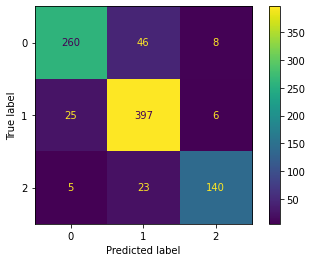

In [ ]:
#For Model batch size 64

cM = confusion_matrix(yTestNew,yPredNew64)

displayClasses = [i for i in range(3)]

print(f1_score(yTestNew, yPredNew64, average='macro'))

disp = ConfusionMatrixDisplay(confusion_matrix=cM, display_labels=displayClasses)
disp.plot()
pyplot.show()